In [1]:
import os

# Pastikan kaggle terpasang
os.system("pip install kaggle")

# Buat direktori untuk file kaggle.json
os.system("mkdir -p ~/.kaggle")

# Pindahkan file kaggle.json ke direktori yang tepat (sesuaikan path kaggle.json di sini)
os.system("cp /path/to/kaggle.json ~/.kaggle/")

# Set permission untuk file kaggle.json
os.system("chmod 600 ~/.kaggle/kaggle.json")

# Download dataset ke /content
os.system("kaggle datasets download -d msambare/fer2013 -p /content")

# Ekstrak file ke /content
os.system("unzip /content/fer2013.zip -d /content")


0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# Ukuran gambar yang akan digunakan (rescale dari 48x48 menjadi 224x224)
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 7  # Karena ada 7 emosi

# Data augmentation untuk data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data augmentation sederhana untuk data testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data menggunakan generator dari direktori
train_generator = train_datagen.flow_from_directory(
    directory='/content/train',
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize gambar menjadi 224x224
    color_mode='rgb',  # Konversi grayscale menjadi RGB
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Untuk klasifikasi multi-kelas
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    directory='/content/test',
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize gambar menjadi 224x224
    color_mode='rgb',  # Konversi grayscale menjadi RGB
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Untuk klasifikasi multi-kelas
    shuffle=False
)

# Load model pre-trained MobileNet tanpa bagian top (lapisan klasifikasi)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
for layer in base_model.layers[:-10]:
    layer.trainable = False

# New layer
x = base_model.output
x = GlobalAveragePooling2D()(x)  # average pooling
x = Dense(512, activation='relu')(x)  # Layer dense
x = Dropout(0.5)(x)  # reduce overfitting
output = Dense(NUM_CLASSES, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# summary model
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,757,255 (14.33 MB)

 Trainable params: 2,116,615 (8.07 MB)

 Non-trainable params: 1,640,640 (6.26 MB)

In [6]:
# Train model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

# Evaluasi model
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Akurasi Pengujian: {test_acc:.2f}")

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 361s 387ms/step - accuracy: 0.3418 - loss: 1.7470 - val_accuracy: 0.5070 - val_loss: 1.2946
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 340s 375ms/step - accuracy: 0.4878 - loss: 1.3500 - val_accuracy: 0.5340 - val_loss: 1.2434
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 374s 368ms/step - accuracy: 0.5278 - loss: 1.2500 - val_accuracy: 0.5385 - val_loss: 1.2187
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 336s 371ms/step - accuracy: 0.5477 - loss: 1.1962 - val_accuracy: 0.5755 - val_loss: 1.1233
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 337s 372ms/step - accuracy: 0.5631 - loss: 1.1535 - val_accuracy: 0.5612 - val_loss: 1.1781
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 337s 373ms/step - accuracy: 0.5784 - loss: 1.1298 - val_accuracy: 0.5853 - val_loss: 1.1028
Epoch 7/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 378s 368ms/step - accuracy: 0.5873 - loss: 1.0910 - val_accuracy: 0.5701 - val_loss: 1.1571
Epoch 8/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 334s 370ms/step - accuracy: 0.5951 - loss: 1.07

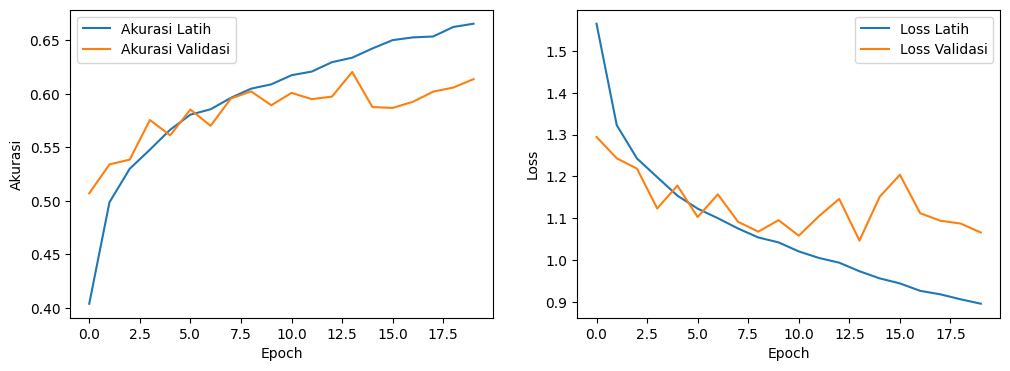

In [7]:
# Cell 7: Visualisasi hasil pelatihan
plt.figure(figsize=(12, 4))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Latih')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Latih')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
Confusion Matrix Per Class (Text Output):
Class: Anger
True Positives: 175
False Positives: 1120
False Negatives: 783
True Negatives: 5090
Precision: 0.1351
----------------------------------------
Class: Disgust
True Positives: 0
False Positives: 36
False Negatives: 111
True Negatives: 7021
Precision: 0.0000
----------------------------------------
Class: Fear
True Positives: 107
False Positives: 711
False Negatives: 917
True Negatives: 5433
Precision: 0.1308
----------------------------------------
Class: Happiness
True Positives: 400
False Positives: 1302
False Negatives: 1374
True Negatives: 4092
Precision: 0.2350
----------------------------------------
Class: Sadness
True Positives: 189
False Positives: 921
False Negatives: 1044
True Negatives: 5014
Precision: 0.1703
----------------------------------------
Class: Surprise
True Positives: 240
False Positives: 1136
False Negatives: 1007
True Negatives: 4785
Precision: 0.1744
--------------

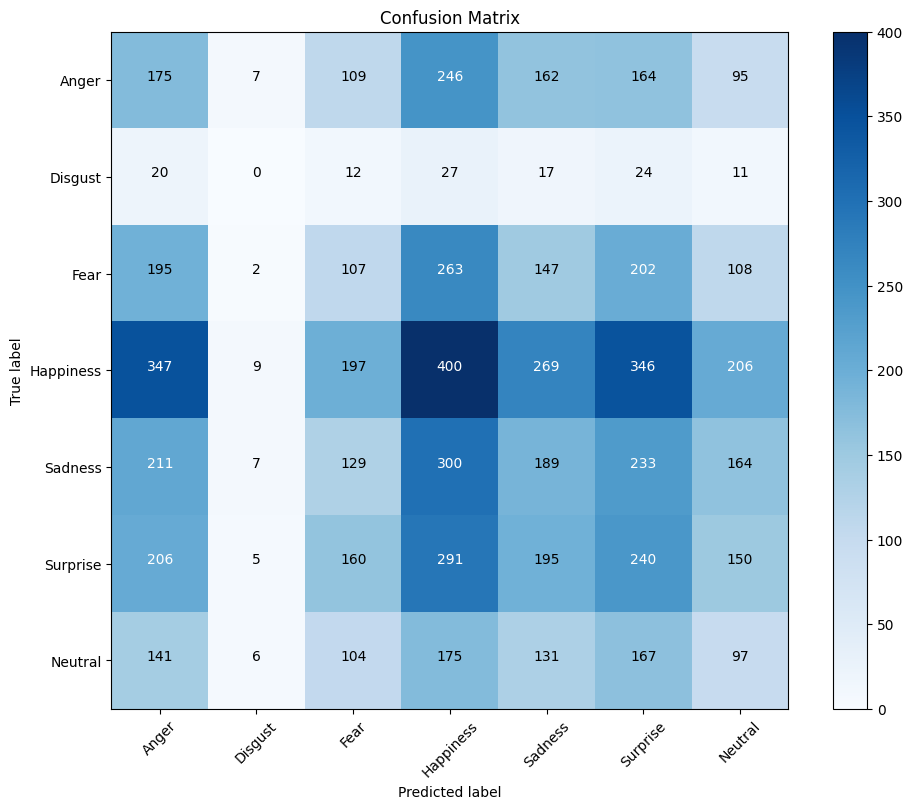

In [ ]:
# Cell 8: Mengimpor pustaka tambahan untuk plot confusion matrix
import itertools
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Fungsi untuk plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Cell 9: Mengambil prediksi dari data uji
y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)

# Mengonversi prediksi menjadi kelas (index kelas dengan probabilitas tertinggi)
y_pred_classes = np.argmax(y_pred, axis=1)

# Mendapatkan label yang sebenarnya (y_true) dan memastikan jumlahnya konsisten dengan y_pred
y_true = test_generator.classes[:len(y_pred_classes)]

# Membuat confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Menampilkan confusion matrix per kelas
print("Confusion Matrix Per Class (Text Output):")
classes = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']
for i, class_name in enumerate(classes):
    true_positives = confusion_mtx[i, i]
    false_positives = np.sum(confusion_mtx[:, i]) - true_positives
    false_negatives = np.sum(confusion_mtx[i, :]) - true_positives
    true_negatives = np.sum(confusion_mtx) - (np.sum(confusion_mtx[i, :]) + np.sum(confusion_mtx[:, i]) - true_positives)

    # Precision calculation
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0

    print(f"Class: {class_name}")
    print(f"True Positives: {true_positives}")
    print(f"False Positives: {false_positives}")
    print(f"False Negatives: {false_negatives}")
    print(f"True Negatives: {true_negatives}")
    print(f"Precision: {precision:.4f}")
    print("-" * 40)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(confusion_mtx, classes=classes)
plt.show()
